In [17]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
import traci.constants as tc
import sumolib

FOLDER_NAME = 'unicamp'

In [18]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

In [19]:
# Code of each variable to subscribe:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

# Simulating and getting the data

In [20]:
def setSpeedMode(vehID, speedMode):
    # bit0: Regard safe speed
    # bit1: Regard maximum acceleration
    # bit2: Regard maximum deceleration
    # bit3: Regard right of way at intersections (only applies to approaching foe vehicles outside the intersection)
    # bit4: Brake hard to avoid passing a red light
    # bit5: Disregard right of way within intersections (only applies to foe vehicles that have entered the intersection)

    # CAUTION: 
    # bit5 has inverted semantics and must be set to '1' in order to disable the safety function. This achieves backward compatibility with earlier versions of SUMO where this bit was not defined and right of way within intersection could not be ignored explicitly.

    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeedMode(vehID, speedMode)

In [21]:
def setSpeed(vehID, speed):
    # Sets the speed of the vehicle to max(speed, MaxVehicleSpeed)
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeed(vehID, speed)

In [22]:
def slowDown(vehID, targetSpeed, duration):
    # Slows down the vehicle to targetSpeed over the next duration seconds
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.slowDown(vehID, targetSpeed, duration)

In [23]:
def get_all_variables(vehIDs, personIDs, useGui=False):
    if useGui:
        traci.start(["sumo-gui", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    else:
        traci.start(["sumo", "-c", f"{FOLDER_NAME}/osm.sumocfg"])
    v_variables = {}
    p_variables = {}
    time = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        for veh_id in traci.simulation.getDepartedIDList():
            if veh_id in vehIDs:
                traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        
        for person_id in traci.simulation.getDepartedPersonIDList():
            if person_id in personIDs:
                traci.person.subscribe(person_id, [tc.VAR_POSITION, tc.VAR_SPEED])

        v_variables[time] = traci.vehicle.getAllSubscriptionResults().copy()
        p_variables[time] = traci.person.getAllSubscriptionResults().copy()
        
        # if time == 0:
        #     setSpeedMode("veh7", 0b10000) 

        # if time == 50:
        #     traci.vehicle.setMaxSpeed("veh7", 20)
        #     setSpeed("veh7", 20)

        # if time == 80:
        #     slowDown("veh7", 0, 20)
        
        time += 1
        traci.simulationStep()
        
    traci.close()
    return v_variables, p_variables

In [24]:
def get_departure_arrival(variables, ID):
    # Devolve o tempo de depareture e arrival de um veículo ou pessoa
    departure = 0
    arrival = 0
    departed = False
    arrived = False
    for x in range(len(variables)):
        if ID in variables[x] and variables[x][ID] and not departed:
            departed = True
            departure = x
        elif ID not in variables[x] and departed:
            arrival = x
            arrived = True
            break
    if not arrived:
        arrival = len(variables)
    return departure, arrival

Função para o plot das variáveis

In [25]:
# IDs of vehicles and persons to subscribe
vehIDs = ["veh1", "veh2", "veh3", "veh4"]
personIDs = []

In [27]:
try:
    veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, useGui=False) # Running the simulation
except Exception as e:
    traci.close() # Close the simulation if there is an error
    print(f"An error occurred: {e}")

 Retrying in 1 seconds
***Starting server on port 59221 ***
Loading net-file from 'unicamp/osm.net.xml.gz' ... done (545ms).
Loading additional-files from 'unicamp/park.add.xml' ... done (28ms).
Loading additional-files from 'unicamp/pa_rerouter.xml' ... done (405ms).
Loading done.
Simulation version 1.21.0 started with time: 0.00.


Simulation ended at time: 1356.00.
Reason: TraCI requested termination.
Performance:
 Duration: 1.18s
 TraCI-Duration: 0.41s
 Real time factor: 1152.08
 UPS: 5596.431606
Vehicles:
 Inserted: 14
 Running: 0
 Waiting: 0
Statistics (avg of 14):
 RouteLength: 5309.46
 Speed: 11.18
 Duration: 470.50
 WaitingTime: 2.86
 TimeLoss: 87.97
 DepartDelay: 1.07
DijkstraRouter answered 45 queries and explored 343.00 edges on average.
DijkstraRouter spent 0.01s answering queries (0.22ms on average).


# Plots and Visualization

In [28]:
def static_plots(variables, ID, isVehicle=True):
    # Plots speed, acceleration, angle and position of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, arrival, 1.0)
    
    if isVehicle:
        fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(18, 5))

    if isVehicle:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0,0].plot(time, speed, label='Speed', color='b')
        ax[0,0].set_xlabel('Simulation step')
        ax[0,0].set_ylabel('Speed (m/s)')
        ax[0,0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1,1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1,1].set_xlabel('X pos')
        ax[1,1].set_ylabel('Y pos')

        acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
        ax[0,1].plot(time, acc, color='g')
        ax[0,1].set_xlabel('Simulation step')
        ax[0,1].set_ylabel('Acceleration(m/s²)')
        ax[0,1].legend()

        angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
        ax[1,0].plot(time, angle, color='purple')
        ax[1,0].set_xlabel('Simulation step')
        ax[1,0].set_ylabel('Angle (degrees)')

    else:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0].plot(time, speed, color='b')
        ax[0].set_xlabel('Simulation step')
        ax[0].set_ylabel('Speed (m/s)')
        ax[0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1].set_xlabel('X pos')
        ax[1].set_ylabel('Y pos')   

    plt.show()

In [29]:
def overleaf_static_plots(variables, ID, xlim, isVehicle=True):
    # Plots speed, acceleration, and angle of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, min(arrival, departure + xlim), 1.0)
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))

    speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
    ax[0].plot(time, speed[:xlim], color='b')
    ax[0].set_xlabel('Simulation step')
    ax[0].set_ylabel('Speed (m/s)')
    # ax[0].set_xlim(xlim)

    acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
    ax[1].plot(time, acc[:xlim], color='g')
    ax[1].set_xlabel('Simulation step')
    ax[1].set_ylabel('Acceleration (m/s²)')
    # ax[1].set_xlim(xlim)

    angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
    ax[2].plot(time, angle[:xlim], color='purple')
    ax[2].set_xlabel('Simulation step')
    ax[2].set_ylabel('Angle (degrees)')
    # ax[2].set_xlim(xlim)

    plt.show()

In [30]:
def separate_plots(variables, sensor_values, sensor_names, vehicle_types, xlim, fig_folder = 'figs'):
    plt.ioff()

    if not os.path.exists(f'{FOLDER_NAME}/{fig_folder}'):
        os.makedirs(f'{FOLDER_NAME}/{fig_folder}')

    IDs = list(vehicle_types.keys())
    types = list(vehicle_types.values())

    times = []
    for ID in IDs:
        departure, arrival = get_departure_arrival(variables, ID)
        times.append(np.arange(departure, min(arrival, departure + xlim), 1.0))

    colors = ['r', 'g', 'b', 'black']

    for i in range(len(sensor_values)):
        fig, ax = plt.subplots(2, len(vehicle_types) // 2, figsize=(20, 10))

        for j, ID in enumerate(IDs):
            values = [variables[x][ID][sensor_values[i]] for x in range(len(variables)) if ID in variables[x]]
            time = times[j]

            row = j // (len(vehicle_types) // 2)
            col = j % (len(vehicle_types) // 2)

            if sensor_values[i] == POSITION:
                sc = ax[row, col].scatter([p[0] for p in values], [p[1] for p in values], c=[k for k in range(len(values))], cmap='viridis', label='Position')
                fig.colorbar(sc, ax=ax[row, col], orientation='vertical', label='Simulation step')
                ax[row, col].set_xlabel('x')
                ax[row, col].set_ylabel('y')
            else:
                ax[row, col].plot(time, values[:xlim], color=colors[i % len(colors)])
                ax[row, col].set_xlabel('Simulation step')
                ax[row, col].set_ylabel(sensor_names[i])

            ax[row, col].set_title(f'{vehicle_types[ID]} style')

        plt.savefig(f'{FOLDER_NAME}/{fig_folder}/{sensor_names[i].split(" ")[0]}.png')
        plt.cla()
        plt.clf()


In [31]:
def get_vehicle_types():
    routes = sumolib.xml.parse(f'{FOLDER_NAME}/finaltrips.rou.alt.xml', "vehicle")
    vehicle_types = {}
    for vehicle in routes:
        veh_id = vehicle.id
        veh_type = vehicle.type
        vehicle_types[veh_id] = veh_type
    
    return vehicle_types

In [32]:
sensor_values = [SPEED, ACCELERATION, ANGLE, POSITION] # Names of the sensors
sensor_names = ["Speed (m/s)", "Acceleration (m/s²)", "Angle (degrees)", "Position"] # Labels of the sensors

# Getting the type of each vechicle based on their IDs
vehicle_types = get_vehicle_types()
print(vehicle_types)

{'veh1': 'v_aggressive4', 'veh2': 'v_normal3', 'veh3': 'v_cautious0', 'veh4': 'v_super_aggressive2'}


In [33]:
separate_plots(veh_variables, sensor_values, sensor_names, vehicle_types, xlim=100, fig_folder='figs') # Separate images for each sensor that are going to be saved at figs folder

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


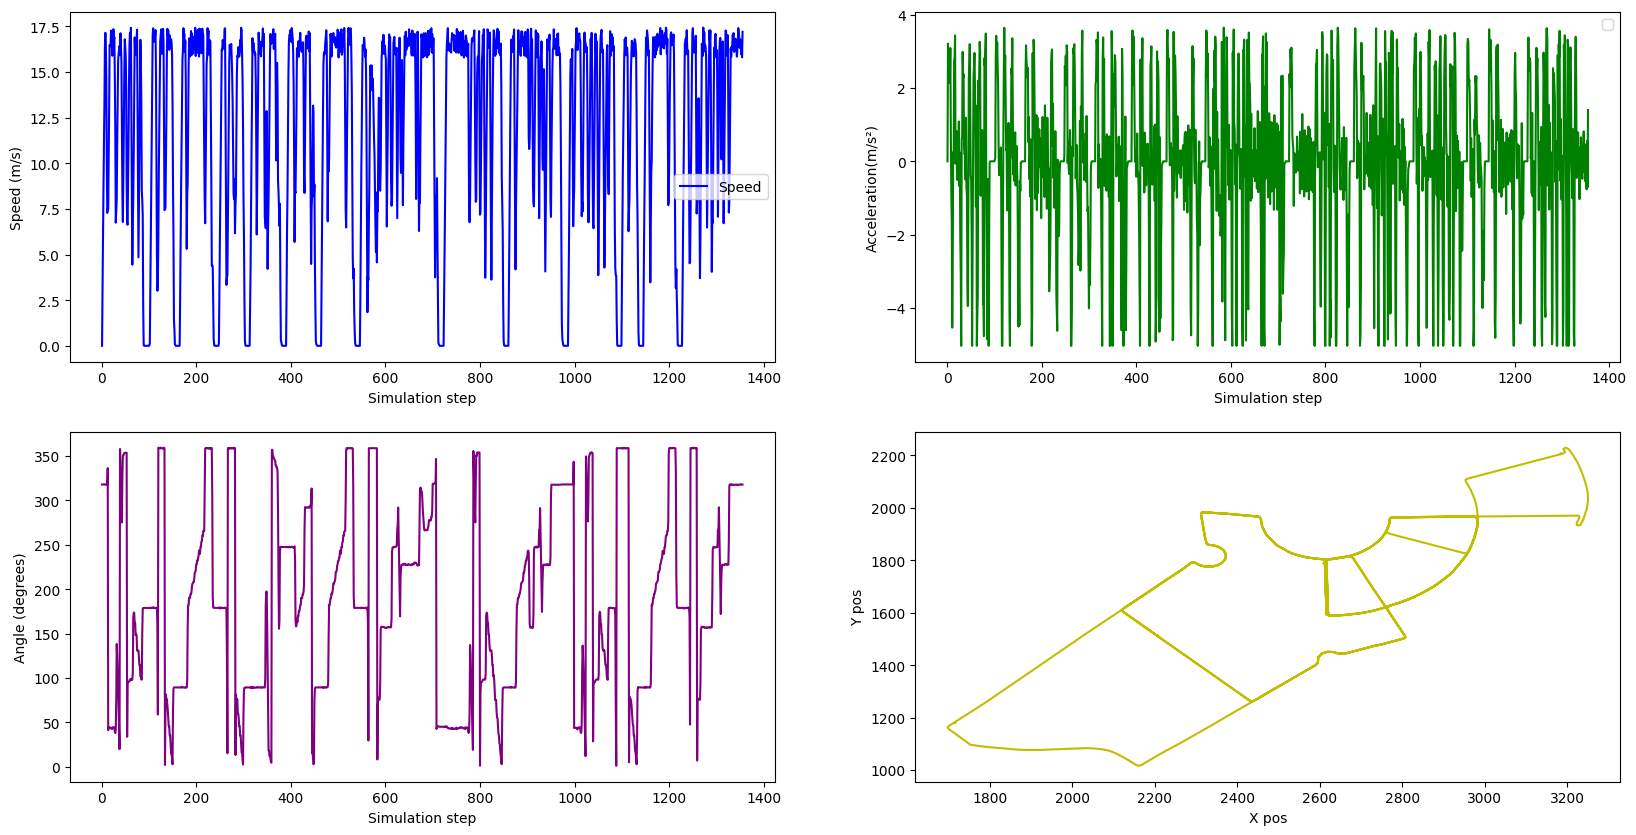

In [34]:
# Plot para o veículo 1 (aggressive)
static_plots(veh_variables, "veh1", True)

Criando gráfico dinâmico que roda juntamente com a simulação: